# Import Libraries

In [13]:
import sys
sys.path.append("/home/felix/PycharmProjects/Quantum-Challenge/")
import pandas as pd
import xarray as xr
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt



# Keywords

Classical approach: selection of the trajectory with the shortest Euclidean distance to the target in order to minimize the distance traveled, i.e. save fuel and time

# TODO

- optimize single 2D trajectory
- function 

# Define Boundaries

x: Longitude

y: Latitude

z: FL 

t: Timestampe

In [5]:
max_x = 30 #deg
min_x = -30 #deg

max_y = 60  #deg
min_y = 34  #deg

spacing_xy = 2

max_z = 400
min_z = 100
spacing_z = 20

In [6]:
start_x = -30
start_y = 56

end_x = 24
end_y = 60

In [9]:
x_arr = np.arange(min_x, max_x + spacing_xy, spacing_xy)
y_arr  = np.arange(min_y, max_y + spacing_xy, spacing_xy)
z_arr   = np.arange(min_z, max_z + spacing_z, spacing_z)

box_3d = np.zeros((x_arr.shape[0], y_arr.shape[0], z_arr.shape[0]))

# Load flight Data 

In [4]:
flight_df = pd.read_csv("../data/flights.csv", sep=";")

<IPython.core.display.Javascript object>


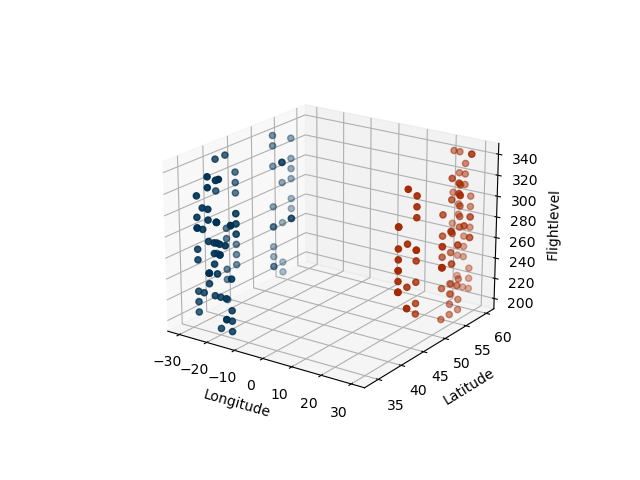

In [120]:
# from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook
flight_dict = flight_df.to_dict()
#sns.set(style = "darkgrid")

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

x_s = np.fromiter(flight_dict["start_longitudinal"].values(), dtype=float)
y_s = np.fromiter(flight_dict["start_latitudinal"].values(), dtype=float)
z_s = np.fromiter(flight_dict["start_flightlevel"].values(), dtype=float)

x_e = np.fromiter(flight_dict["end_longitudinal"].values(), dtype=float)
y_e = np.fromiter(flight_dict["end_latitudinal"].values(), dtype=float)
z_e = np.fromiter(flight_dict["start_flightlevel"].values(), dtype=float)


ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_zlabel("Flightlevel")

ax.scatter(x_s, y_s, z_s,c="#003153")
ax.scatter(x_e, y_e, z_e, c="#A42A04")

#ax.invert_zaxis()

plt.show()

# Load speed/fuel data

In [18]:
fuel_df = pd.read_csv("../data/bada_data.csv", sep=";")
cruise_df_temp = pd.read_csv("../data/bada_data.csv", sep=";").iloc[:,[0,1,2]]
climb_df = pd.read_csv("../data/bada_data.csv", sep=";").iloc[:,[0,3,4,5]]
descent_df = pd.read_csv("../data/bada_data.csv", sep=";").iloc[:,[0,6,7,8]]

In [19]:
cruise_df = cruise_df_temp.drop(index=[0,1,2,3,4,5,6,7,8]).reset_index() # remove FL below 100

# Load climate data

In [159]:
convert_dict = {
    600: [100,120,140], 
    550: [160], 
    500: [180], 
    450: [200,220], 
    400: [240], 
    350: [260,280], 
    300: [300,320],
    250: [340], 
    225: [360], 
    200: [380,400]} 

In [162]:
ds = xr.open_dataset("../data/aCCF_0623_p_spec.nc")
climate_df_temp = ds.to_dataframe()
climate_df = climate_df_temp.reset_index()
climate_df.drop(columns=["LEVEL11_24_bnds","bnds","SG_NOX","SG_DCONT","SG_H2O","E022"], inplace=True)
climate_df.drop(climate_df[climate_df.LONGITUDE<-30].index, inplace=True)
climate_df = climate_df.reset_index()

hpa_old = climate_df["LEVEL11_24"].to_numpy()
fl_mapped = []#np.zeros(len(hpa_old))
rem_index = []

for i in range(len(hpa_old)):
    if hpa_old[i] in convert_dict:
        #fl_mapped[i] = convert_dict[hpa_old[i]]
        fl_mapped.append( convert_dict[hpa_old[i]])
    else:
        #fl_mapped[i] = float("nan") 
        fl_mapped.append(float("nan")  )
        rem_index.append(i)


climate_df["FL"] = fl_mapped
climate_df.drop(rem_index, inplace=True)
climate_df = climate_df.reset_index()
climate_df.drop(columns=["level_0","index"],inplace=True)

# Define functions to relate measured data to parametrized voxels

In [54]:
def x_to_km(deg):
    "return km"
    return deg*85

def y_to_km(deg):
    "return km"
    return deg*111

In [126]:
def find_x(x_hat):
    inx = (np.abs(x_arr - x_hat)).argmin()
    return x_arr[inx]

def find_y(y_hat):
    inx = (np.abs(y_arr - y_hat)).argmin()
    return y_arr[inx]

def find_z(z_hat):
    inx = (np.abs(z_arr - z_hat)).argmin()
    return z_arr[inx]


In [52]:
def find_fuel(df, FL_val):
    """"returns TAS and fuel consumption in kg/min """
    inx = (np.abs(df["FL"].to_numpy() - FL_val )).argmin()
    cl_inx = df.index[inx]
    return df.iloc[cl_inx].values[2],float(df.iloc[cl_inx].values[3].replace(",","."))

find_fuel(cruise_df,250)

(425.0, 46.6)

In [59]:
#The trajectory for each airplane is defined as a list of points, altitudes, and time stamps
def consumed_fuel(trajectory):
    c_fuel = 0 
    for cnt in range(len(trajectory)-1):
        #delta_x = np.abs(trajectory[cnt+1]["x"] - trajectory[cnt]["x"] )
        #delta_y = np.abs(trajectory[cnt+1]["y"] - trajectory[cnt]["y"] )
        z = trajectory[cnt+1]["z"] 
        delta_t = np.abs(trajectory[cnt+1]["t"] - trajectory[cnt]["t"] ).astype(float)
        
        consumption_rate = find_fuel(cruise_df,z)[-1] # in kg/min
        
        c_fuel += consumption_rate * delta_t/60 
                
    return c_fuel
#test_traj = [{"x": 25, "y":50, "z":400 , "t":np.datetime64("2018-06-23 06:00:00")  }, {"x": 27, "y":50, "z":400 , "t": np.datetime64("2018-06-23 12:00:00") }]

# Define navigation functions

In [53]:
def rad_change_direction(v,angle):
    rad = angle*np.pi/180
    return v**2/(np.tan(rad))*0.0000269
rad_change_direction(400,25)
# normalized to km

9.229957785873141

# Define Cost function and constraints

In [ ]:
# constraining parameters
con_vertical = 1000 # ft
con_horizont = 5 #NM
con_range = 3300 #NM
con_inclination = 25 #deg only above this

In [74]:
def C(trajectory):
    
    c_fuel = consumed_fuel(trajectory) # kg 
    
    #delta_CO2 = 6.94 * 10**(-12) # K/kg fuel
    
    effect_sum = np.sum([find_climate(climate_df, x=point["x"], y=point["y"], z=point["z"], t=point["t"]) for point in trajectory])
    
    delta_c = effect_sum*10**(-12) # K/kg fuel
    
    return (delta_c)*c_fuel

2.571302233640753e-07

# Optimize flights classicaly

In [98]:
trajec_arr = []
for index, t, z, x_s, y_s, x_e, y_e in flight_df.to_numpy():
    
    delta_x = x_to_km(np.abs(x_e-x_s))
    delta_y = y_to_km(np.abs(y_e-y_s))
    total_dist = np.sqrt(delta_x**2 + delta_y**2)

    x_tr = np.linspace(x_s,x_e,100)
    y_tr = np.linspace(y_s,y_e,100)
    fl_tr = np.ones(100)*z
    t_tr = [np.datetime64('2018-06-23 '+t)]
    
    temp_trajec = []
    for i in range(99):
        point_x = x_to_km(x_tr[i+1] - x_tr[i])
        point_y = y_to_km(y_tr[i+1] - y_tr[i])
        point_dist = np.sqrt(point_x**2 + point_y**2)
        # point fl soon

        point_t = int(3600 * point_dist/ (find_fuel(cruise_df,z)[0] * 1.852))

        t_tr.append(t_tr[i] + np.timedelta64(point_t,'s'))
        temp_trajec.append({"x": x_tr[i+1], "y":y_tr[i+1], "z":z , "t":t_tr[i] + np.timedelta64(point_t,'s')  })
    trajec_arr.append(temp_trajec)

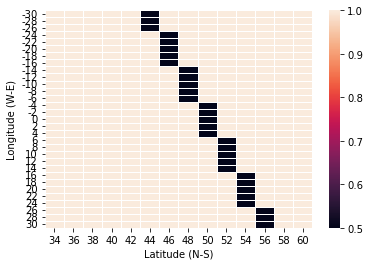

In [113]:
tr_1 = trajec_arr[44]
box_2d = np.zeros((x_arr.shape[0], y_arr.shape[0]))
for c_1, i in enumerate(x_arr):
    for c_2, j in enumerate(y_arr):
        
        box_2d[c_1][c_2] = 1
        
        for c_3, l in enumerate(tr_1):

            if i == x_arr[(np.abs(x_arr - tr_1[c_3]["x"]  )).argmin()] and j == y_arr[(np.abs(y_arr - tr_1[c_3]["y"]  )).argmin()]:
                box_2d[c_1][c_2] = 0.5
                            
ax = sns.heatmap(box_2d,xticklabels= y_arr, yticklabels=x_arr, linewidths=0.5)
ax.set_ylabel("Longitude (W-E)")
ax.set_xlabel("Latitude (N-S)")
plt.show()

In [206]:
import traceback

def find_climate(df, x, y, z, t):
    
    scaled_x = find_x(x)
    scaled_y = find_y(y)
    scaled_z = find_z_arr(z)
    
    index_arr = []
    for cnt, fl in enumerate(df["FL"].to_numpy()):
        if fl == scaled_z:
            index_arr.append(True)
        else:
            index_arr.append(False)
    
    temp_series = df.loc[(df["LONGITUDE"] == scaled_x) & (df["LATITUDE"] == scaled_y) & (index_arr), "TIME"].dt.hour
    try:    
        inx = (np.abs(temp_series.to_numpy() - ( (t-t.astype('datetime64[D]'))/3600).astype(int)   )).argmin()
    except:
        print(scaled_x,scaled_y,scaled_z,temp_series)
        print(traceback.format_exc()) 
        inx = 0 
    cl_inx = temp_series.index[inx]
    ret = df.iloc[cl_inx].values[-2]
    
    return ret 

# find_climate(climate_df, x=30, y=56, z=400, t=np.datetime64("2018-06-23 06:00:00"))

In [205]:
df.loc[(df["LONGITUDE"] == -30) & (df["LATITUDE"] == 60) & ( index_arr), "TIME"].dt.hour

816     6
817    12
818    18
819     6
820    12
821    18
Name: TIME, dtype: int64

In [176]:
def find_z_arr(z_hat):
    
    nearest_val = z_hat
    difference = z_hat
    
    for cnt, arr in enumerate(convert_dict.values()):
        for test_fl in arr:
            if np.abs(test_fl - z_hat) < difference:
                nearest_val = arr
                difference = np.abs(test_fl - z_hat)
    
    return nearest_val


2604

In [186]:
df = climate_df
# df.loc[(df["LONGITUDE"] == -30) & (df["LATITUDE"] == 56) & (df["FL"] == 300), "TIME"].dt.hour
# df.loc[(df["LONGITUDE"] == -30) & (df["LATITUDE"] == 56) ]

df.loc[(df["FL"].isin([200,220]) ) ]

Empty DataFrame
Columns: [LONGITUDE, LATITUDE, LEVEL11_24, TIME, MERGED, FL]
Index: []

In [207]:
classical_delta_T = np.sum([C(tr) for tr in trajec_arr])

In [208]:
classical_delta_T

1.4608048691998272e-05